<a href="https://colab.research.google.com/github/lrrong2020/A/blob/main/FYP_Pro_T4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Prep

In [3]:
%cd /content/gdrive/MyDrive/Kaggle/unzip/

/content/gdrive/MyDrive/Kaggle/unzip


#GitHub

In [45]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.
import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader #For working with data.
from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

#manual seed for reproductivity and potential performance improvement
torch.manual_seed(3407)

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cpu


In [51]:
path = "/content/"

#label csv
all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split
# subset for hyperparameters tuning

part = 0.90
train_df, drop_df = train_test_split(all_df, test_size=part, random_state=42)
test_sample_size = round(7000 * (1 - part) )  #roughtly 1/3
train_df, test_df = train_test_split(train_df, test_size=test_sample_size, random_state=42)

# Assuming train_df is your original training DataFrame
# test_sample_size = 7000 # roughtly 1/3
# train_df, test_df = train_test_split(all_df, test_size=test_sample_size, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 2530
No.of.testing_samples: 700
No.of.val_samples: 282


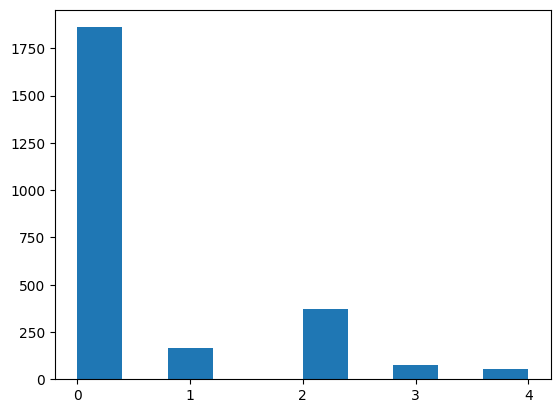

In [52]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [53]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.2719, 3.0299, 1.3602, 6.8378, 9.0357])


In [9]:
#For getting a random image from our training set.
# num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
# sample_image = (f'{path}train/{train_df["image"][num]}.jpeg')#Image file.
# sample_image = Image.open(sample_image)
# plt.imshow(sample_image)
# plt.axis('off')
# plt.title(f'Class: {train_df["level"][num]}') #Class of the random image.
# plt.show()

In [54]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.


In [55]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_set = dataset(train_df,f'{path}train',image_transform=image_transform)
test_set = dataset(test_df,f'{path}train',image_transform=image_transform)
valid_set = dataset(valid_df,f'{path}train',image_transform=image_transform)

In [64]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2)

In [65]:
from torchvision.models import resnet50,ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
)

In [66]:
model = model.to(device) #Moves the model to the device.

In [67]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.


        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        #for memory
        torch.cuda.empty_cache()

        # Print some information every 100 batches
        if batch % 70 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, '/content/gdrive/MyDrive/Kaggle/unzip/DR_ResNet50_test.pt')
    return avg_loss, accuracy

In [68]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [69]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'g', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [70]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    # scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)


        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')

            # Save to CSV
            df.to_csv('training_validation_metrics.csv', index=False)
            break

        # Step the learning rate scheduler
        # scheduler.step()
        scheduler.step(valid_loss)

        df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)

    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses

In [ ]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005, weight_decay=5e-4)
nb_epochs = 500
patience = 500

#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)


Epoch 1/500
-------------------------------
Epoch: 0, Learning Rate: 0.005000 
Batch 0/159 processed, running loss: 1.640602, correct predictions: 2, total: 16


In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/unzip

In [ ]:
model = torch.load("DR_ResNet50_test.pt")
model.eval()  # Set the model to evaluation mode

# Store all the model predictions for the test set
all_preds = []
all_labels = []

# No need to track gradients for evaluation, saves memory and computations
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# For multiclass case:
num_classes = cm.shape[0]  # assuming cm is a square matrix

for i in range(num_classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp  # sum across the row, excluding the diagonal element
    fp = cm[:, i].sum() - tp  # sum down the column, excluding the diagonal element
    tn = cm.sum() - fn - fp - tp

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"For class {i}, Sensitivity: {sensitivity}, Specificity: {specificity}")


In [ ]:
!nvidia-smi

In [19]:
!pwd

/content/gdrive/MyDrive/Kaggle/unzip


In [20]:
!zip -r data.zip test train

Streaming output truncated to the last 5000 lines.
  adding: train/14849_left.jpeg (deflated 3%)
  adding: train/14849_right.jpeg (deflated 5%)
  adding: train/14850_left.jpeg (deflated 5%)
  adding: train/14844_right.jpeg (deflated 10%)
  adding: train/14850_right.jpeg (deflated 5%)
  adding: train/14856_left.jpeg (deflated 12%)
  adding: train/14856_right.jpeg (deflated 12%)
  adding: train/14852_left.jpeg (deflated 10%)
  adding: train/14852_right.jpeg (deflated 9%)
  adding: train/14855_left.jpeg (deflated 14%)
  adding: train/14855_right.jpeg (deflated 11%)
  adding: train/14863_left.jpeg (deflated 8%)
  adding: train/14858_left.jpeg (deflated 4%)
  adding: train/14863_right.jpeg (deflated 7%)
  adding: train/14858_right.jpeg (deflated 4%)
  adding: train/14877_left.jpeg (deflated 6%)
  adding: train/14877_right.jpeg (deflated 6%)
  adding: train/14867_left.jpeg (deflated 10%)
  adding: train/14867_right.jpeg (deflated 10%)
  adding: train/14874_left.jpeg (deflated 7%)
  adding: t

In [42]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/data.zip /content

In [43]:
!pwd
!ls

/content
data.zip  gdrive  sample_data


In [44]:
!unzip -nq /content/data.zip

In [ ]:
!rm /content/data.zip

In [37]:
%cd /content

/content


In [38]:
!ls

data.zip  gdrive  sample_data


In [63]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005, weight_decay=5e-4)
nb_epochs = 500
patience = 500

#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)


Epoch 1/500
-------------------------------
Epoch: 0, Learning Rate: 0.005000 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: 